<a href="https://colab.research.google.com/github/audreywang1997/CMPBIO293_Fall2024/blob/main/Tutorial2_DimensionalityReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial 2: PCA, t-SNE, and UMAP

This tutorial is adapted from multiple resources:

*   Justin Bois and Caltech's [BE/Bi 103](https://https://bebi103a.github.io/) a course staff
*   2016 Heidi Klumpe and Manuel Razo
*   (c) 2016 Heidi Klumpe. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT). Some code from the scikit-learn tutorial are [BSD licensed](https://opensource.org/licenses/BSD-3-Clause).
*   Berkeley's CS189/289A



###Download libraries and packages

In [1]:
pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
from time import time

# Packages to perform dimensionality reduction
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold
import umap
from umap import UMAP

# Packages for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import offsetbox
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

###PCA in the biological sciences

#### The famous iris data set

We will use one of the most famous datasets available online. This dataset, collected by Edgar Anderson, contains the petal and sepal length and width in three different species of Iris (*Iris setosa*, *Iris virginica* and *Iris versicolor*).

This data set is popular enough to have its own [Wikipedia entry](https://en.wikipedia.org/wiki/Iris_flower_data_set), and you can import it with [seaborn](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html?highlight=iris), [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), or even pandas using

    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    df = pd.read_csv(filepath_or_buffer=url, header=None, sep=',')

For this tutorial, we will import it using `scikit-learn` and transform it into a tidy data frame.

In [4]:
# Import the Iris dataset and convert it into a Pandas DataFrame
iris = sklearn.datasets.load_iris()

# Uncomment if you want to print the dataset description
# print(iris.DESCR)

# Make a DataFrame with a species column
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Take a look at df_iris
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can plot pairwise comparisons using Seaborn's `pairplot()` function to see if there are striking correlations between any two features of the iris data set. If any two features are highly correlated, we may assume we can summarize those two features with a single axis (i.e. "new" feature) that includes both.

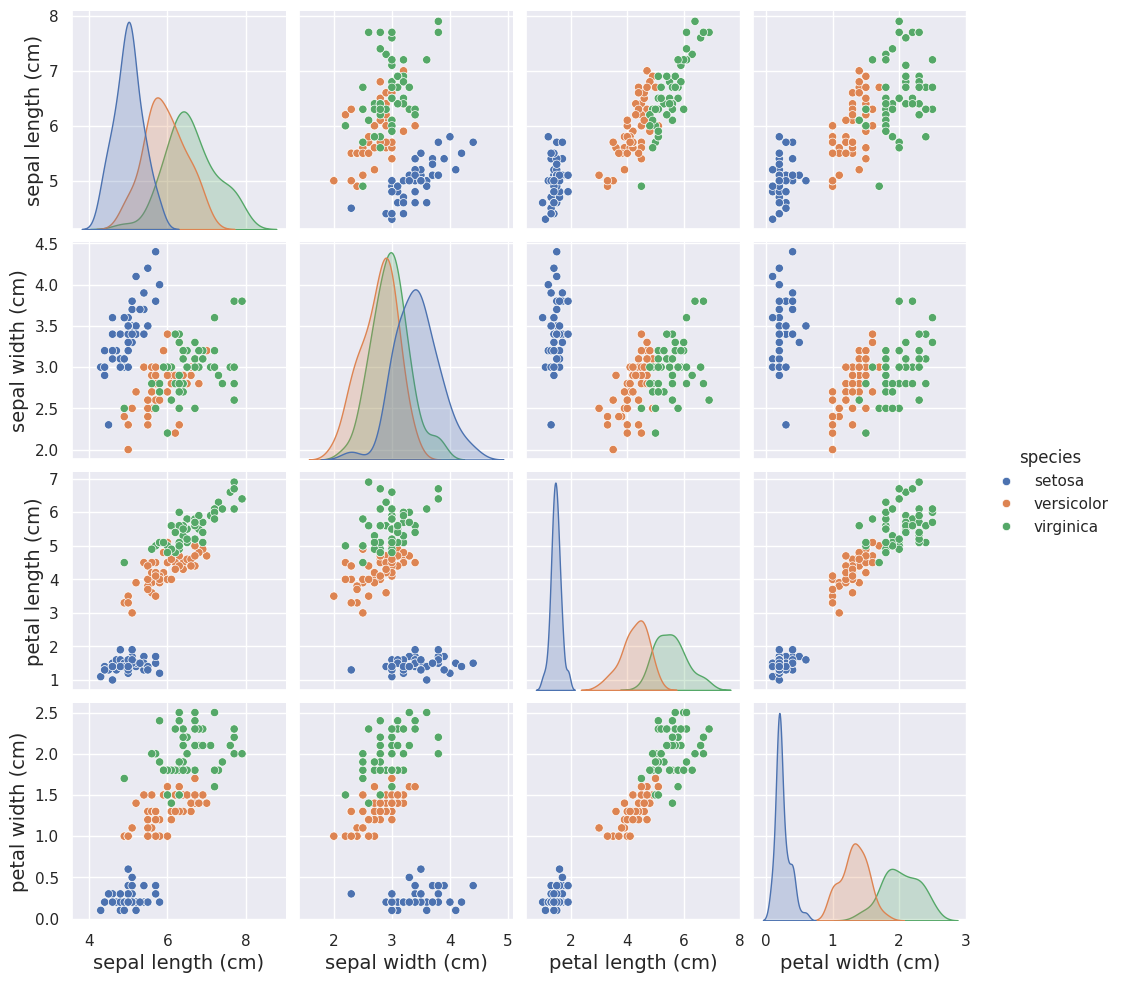

In [5]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar to each other than to *setosa*.  There is also a strong correlation between *petal length* and *petal width*. We can use this to explain the concept behind PCA. So, let's focus on these two parameters.

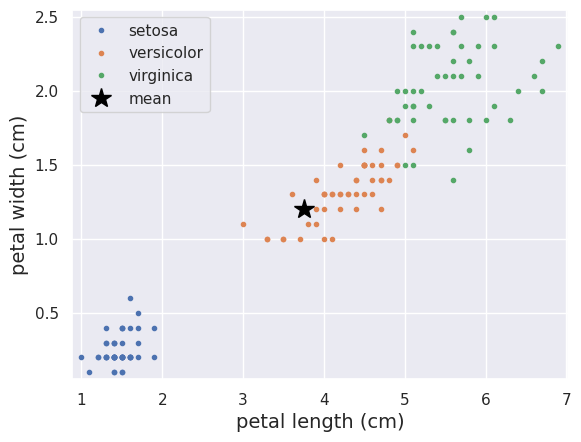

In [6]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(),
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

Now, we do PCA by hand. Our goal will be to reduce our 2-D data to 1-D. Note that by taking the mean, we already reduced it 0-D in a sense.

**1) Standardize the data.**
PCA looks for the directions of greatest variation. If one of our measurements is inherently more variable, PCA will pay too much attention to it. A common standardization trick is to subtract the mean and divide by the standard deviation. Then, each measurement represents "standard deviations from the mean" instead of centimeters.  

In [7]:
# Substract the mean from the measurements.
df_centered = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
for col in df_centered.columns:
    df_centered[col]  = (df_centered[col] - df_centered[col].mean()) / df_centered[col].std()

# Take a look
df_centered.head()

,petal length (cm),petal width (cm)
0,-1.335752,-1.311052
1,-1.335752,-1.311052
2,-1.392399,-1.311052
3,-1.279104,-1.311052
4,-1.335752,-1.311052


**2) Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.**

We won't cover the math behind this procedure. However, [it can be shown](https://en.wikipedia.org/wiki/Principal_component_analysis#First_component) that the principal component directions are given by the eigenvectors of the matrix, and the magnitudes of the components are given by the eigenvalues.

Most of the available algorithms to do PCA use [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) instead for computational efficiency. But regardless of the algorithm the objective is still the same: compute the eigenvectors and eigenvalues from the covariance matrix.

In [8]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

Covariance matrix 
 [[1.         0.96286543]
 [0.96286543 1.        ]]


Next, we'll compute the eigensystem.

In [9]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# sort from largest to smallest
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]
print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Eigenvectors
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

Eigenvalues
 [1.96286543 0.03713457]


We can plot the eigenvectors on top of our data to get a sense of how these principal components can capture the variation in the data.

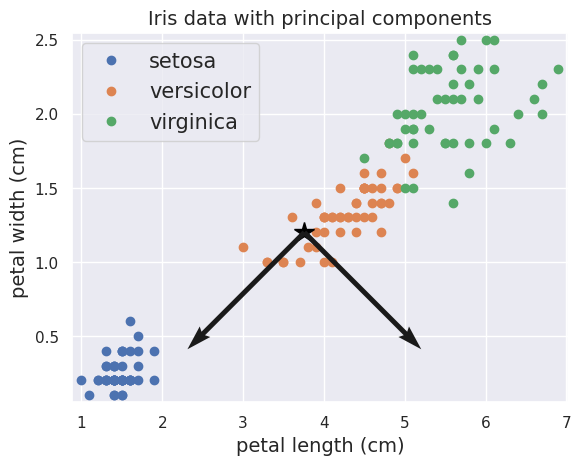

In [10]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11,
           width=0.01, scale=3)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris data with principal components');

**3) Select the $k$ largest eigenvalues and their associated eigenvectors.**

As [Sebastian Raschka](http://sebastianraschka.com/index.html) points out in his explanation of PCA:

>*The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes*.

We chose this pair of measurements originally because there was a clear correlation between them. This is indeed confirmed by the relative magnitudes of the *eigenvalues* where one of them is two orders of magnitude larger than the other. Clearly, describing this data with two axes, rather than one, does not add much additional information. Also, we know which eigenvector to take: the one with the largest eigenvalue.

[Lior Pachter's great blog post on PCA](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/), which we will discuss more later, explains this 2-D to 1-D case by thinking of the projection as a triangle. Let's say we want to project a single data point onto the first principal component. The centroid (fixed) and the data point (also fixed) form a triangle with the the transformed data point (an orthogonal projection onto the first principal component).

The hypotenuse of the triangle (the distance from the centroid to the data point) is fixed, so the other two sides must change together (by the Pythagorean Theorem). The first principal component has a minimal orthogonal distance to all the data points. So the side of the triangle between the data point and the transformed data point is as small as possible. This means the distance between the centroid and the transformed point is as large as possible (though still smaller than the original distance between the data point and the centroid)!

This is what we mean when we say that using PCA to project the data into fewer dimensions maximizes the sample variation (i.e. their distances from each other after they've been transformed), despite some information being lost.

Luckily, we can quantify about how much information is lost. As the eigenvalues are a relative measure of the data variance along the associated eigenvector (i.e. the "new feature axis"), we can use them to quantify how much of the variance is explained by our $k$ dimensions, which could be a useful way to decide what $k$ should even be in the first place. In this case, we want to know how much of the 2-D spread is described by our 1-D simplification.

In [11]:
# Compute how much variance is explained by each principal component
print("""
PCA 1: {0:.2f}% of the variance
PCA 2:  {1:.2f}% of the variance
""".format(*tuple(eig_vals / np.sum(eig_vals) * 100)))


PCA 1: 98.14% of the variance
PCA 2:  1.86% of the variance



**4) Transform the data into a $k$ dimensional subspace using those $k$ eigenvectors.**

To actually project our data into this new dimension, we have to multiply our data by the so-called projection matrix, which is the concatenation the top $k$ eigenvectors. Each of these eigenvectors represents a direction of high variation in the dataset. Multiplying our samples by these directions scores how far in each direction each sample lands.

Since in this simple example we are projecting into a 1D space, we just have to matrix multiply our data by the eigenvector with the largest corresponding eigenvalue.

In [12]:
# Project data to our 1D space
df_1D = pd.DataFrame(np.dot(df_iris.loc[:,['petal length (cm)',
                                           'petal width (cm)']], eig_vecs[:,0]),
                     columns=['projection'])

# Add back the species column
df_1D['species'] = df_iris['species']
df_1D.head()

,projection,species
0,-1.131371,setosa
1,-1.131371,setosa
2,-1.060660,setosa
3,-1.202082,setosa
4,-1.131371,setosa


Now we can plot our data in 1D only while maintaining ≈98% percent of the variability in the data!

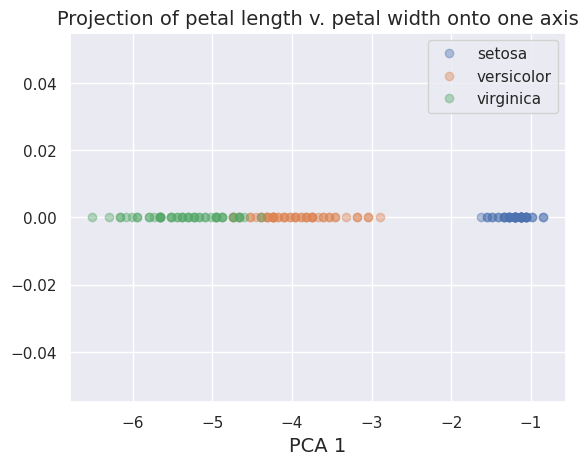

In [13]:
for key, group in df_1D.groupby(['species']):
    plt.plot(group['projection'], np.zeros_like(group['projection']), alpha=0.4,
             label=key, marker='o', linestyle='none')

plt.margins(0.05)
plt.xlabel('PCA 1')
plt.legend(np.array(['setosa', 'versicolor','virginica']))
plt.title('Projection of petal length v. petal width onto one axis');

Exciting! We were able to project 2-D data onto a 1-D axis, and still have a sense of how these various iris species differ. Note that while the new dimension has numerical values, its interpretation is a bit fuzzy. It's in fact a weighted combination of *petal length* and *petal width*, but this doesn't necessarily tell us anything new about biology, except that these two variables are related and potentially very different in various iris species. However, we might have known this by computing their covariance.

### `Scikit-learn` shortcut for PCA

Now that we explored step-by-step how to do PCA, we can use `scikit-learn` to do it in a single line.  For this, we will take all 4 dimensions of the original dataset (petal length, petal width, sepal length, and sepal width) and explore how much variability is explained by each of the resulting principal components.

`Scikit-learn` utilizes Python's object orientation. An object is first instantiated by the user, and has various variables (i.e. class and instance variables) and methods (i.e. functions) you can access (more definitions [here](https://www.tutorialspoint.com/python/python_classes_objects.htm)). We first instantiate a `sklearn.decomposition.PCA` object, and the use the `fit()` method to get PCA on our data.  The attributes of the `PCA` instance that end in underscores are the computed values.

In [14]:
# Instantiate the PCA object
sklearn_pca = sklearn.decomposition.PCA()

## transform the data
scaled_data = (df_iris[iris.feature_names] - df_iris[iris.feature_names].mean()) / df_iris[iris.feature_names].std()

# Pass the data to the fit method
sklearn_pca.fit(scaled_data)
#sklearn_pca.fit(df_iris[iris.feature_names])

# Print the variance explained
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [0.72962445 0.22850762 0.03668922 0.00517871]


We can see that the first component captures 73% of the variability in the data! We can now easily project our 4-D dataset into any $k$ dimensional space we would like. Since we've already seen a 0-D and 1-D reduction, let's look at the data in 2-D space.

In [15]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(scaled_data)

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(scaled_data),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['species'] = df_iris['species']

# Look at the result
df_2D.head()

,PCA1,PCA2,species
0,-2.257141,0.478424,setosa
1,-2.074013,-0.671883,setosa
2,-2.356335,-0.340766,setosa
3,-2.291707,-0.595400,setosa
4,-2.381863,0.644676,setosa


Now we can plot our original 4-D data onto a 2-D space that retains nearly 96% of the variability.

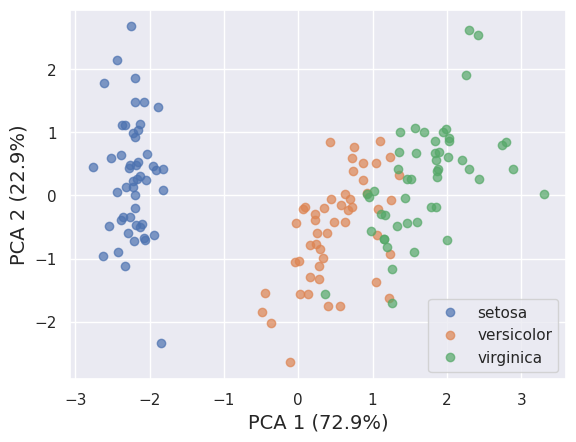

In [16]:
for key, group in df_2D.groupby(['species']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0)
plt.margins(0.05)
plt.xlabel('PCA 1 (72.9%)')
plt.ylabel('PCA 2 (22.9%)');

### Non linear methods

Below is an example adapted from the `scikit-learn` documentation on [manifold learning](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), written by Fabian Pedegrosa, Olivier Grisel, Mathieu Blondel, and Gael Varoquaux. We will compare linear and non-linear dimensionality reduction to create clusters of hand-drawn digits. We can import a dataset of these hand-drawn numbers from the `sklearn` module.

We will use t-SNE and UMAP. Unlike PCA, these do not preserve the global structure of the dataset. Instead, they try to find a low dimensional space where the local area around each point matches the local area in the high dimensional space.


MNIST is a database. The acronym stands for “Modified National Institute of Standards and Technology.” The MNIST database contains handwritten digits (0 through 9), and can provide a baseline for testing image processing systems.



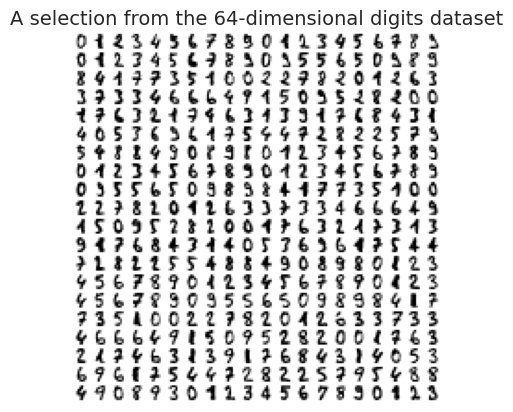

In [17]:
# Load the data from sklearn
digits = sklearn.datasets.load_digits(n_class=10)

# Store the data and targets
digit_images = digits.data
digit_classes = digits.target

# The data are rows of pixel values, and each pixel value is a feature (64 pixels in an 8x8 image).
n_samples, n_features = digit_images.shape

# Take a look at the data
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10*i + 1
    for j in range(n_img_per_row):
        iy = 10*j + 1
        img[ix:ix + 8, iy:iy + 8] = digit_images[i * n_img_per_row + j].reshape((8,8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');

Data Set Characteristics:

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

In the [tutorial](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), they define a function to plot a picture of each number, rather than merely a point. This will be useful for determining the success of clustering.

In [18]:
def plot_embedding(embed, title=None, show_classes=True, show_examples=True):
    # Determine range of values of embedded points
    x_min, x_max = np.min(embed, 0), np.max(embed, 0)
    # Scale all points between 0 and 1
    scaled_embed = (embed - x_min) / (x_max - x_min)

    # Instantiate figure
    plt.figure()
    ax = plt.subplot(111)

    if show_classes:
        # Color each number differently (shows how we expect data to cluster)
        for i in range(scaled_embed.shape[0]):
            plt.plot(scaled_embed[i,0], scaled_embed[i,1], '.',
                     color = plt.cm.Set1(digit_classes[i]/10))
    else:
        plt.plot(scaled_embed[:,0], scaled_embed[:,1], '.k')

    if show_examples:
        if hasattr(offsetbox, 'AnnotationBbox'):
            # Only print thumbnail with matplotlib > 1.0;
            # initialize shown_images array
            shown_images = np.array([[1, 1]])

            # Iterate through the number of digits we imported
            for i in range(digits.data.shape[0]):
                dist = np.sum((scaled_embed[i] - shown_images) **2, 1)
                # Don't put thumbnails too close together
                if np.min(dist) < 4e-3:
                    continue
                # Concatenate the  locations of the images to be plotted
                shown_images = np.r_[shown_images, [scaled_embed[i]]]
                # Define the grayscale image of the number
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    scaled_embed[i])
                ax.add_artist(imagebox)

    # Remove x and y ticks
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Now, we will use PCA (our linear approach) and t-SNE and UMAP (our non-linear approaches) to reduce this 64-dimensional dataset to 2 dimensions. (We will discuss the t-SNE syntax in more detail later on.) Keep in mind that each "dimension" is the grayscale value of each pixel in the image of the hand-drawn digit. We want to see if the structure of the data (i.e. what we know about which images are 0s, 1s, 2s, etc.) is visible in 2D.

In [19]:
# Time the PCA computation
t0 = time()  # Use time.time() to get the correct timing
# Use PCA for dimensionality reduction
digit_pca = sklearn.decomposition.PCA(n_components=2)
# Transform the data
embed_pca = digit_pca.fit_transform(digit_images)
# Store the time
t_pca = time() - t0
# Print time
print('PCA took %.3fs.' % t_pca)

# Time the t-SNE computation
t0 = time()
# Find the optimal low-dimensional representation with t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_tsne = tsne.fit_transform(digit_images)
# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.3fs.' % t_tsne)

# Time the UMAP computation
t0 = time()

# Find the optimal low-dimensional representation with UMAP
umap = umap.UMAP()
embed_umap = umap.fit_transform(digit_images)  # Use the reducer object here

# Store the time
t_umap = time() - t0

# Print time
print('UMAP took %.3fs.' % t_umap)


PCA took 0.009s.
t-SNE took 31.436s.
UMAP took 20.854s.


Wow. We can already see that t-SNE takes almost 100 times longer. We can compare the results by plotting the resulting low-dimensional spaces (also called the embedding).

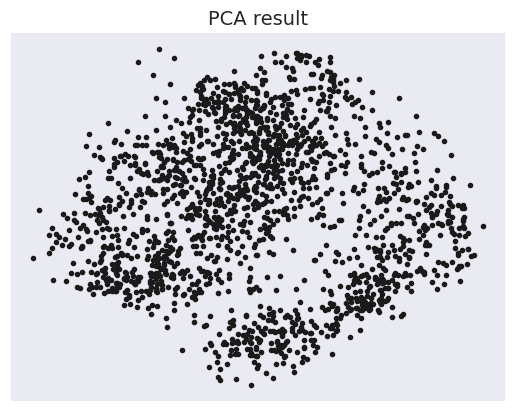

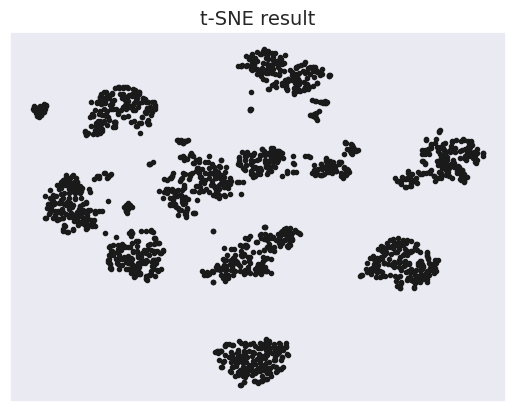

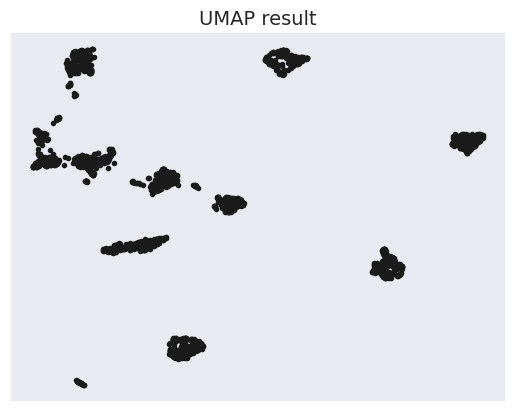

In [20]:
plot_embedding(embed_pca, "PCA result", show_classes=False, show_examples=False)
plot_embedding(embed_tsne, "t-SNE result", show_classes=False, show_examples=False)
plot_embedding(embed_umap, "UMAP result", show_classes=False, show_examples=False)

Here, we see PCA fails to give us what we were after, which is a clean separation of digits into clusters.

In contrast, t-SNE and UMAP show distinct groups. There are roughly 7-8 clusters, depending on how you count. This is intriguing as we know there are 6 hand-drawn digits, ranging from 0 to 5.

To get a better idea of what these maps are trying to communicate, let's color each point by the digit it represents, and overlay them with a few images of those hand-drawn digits.

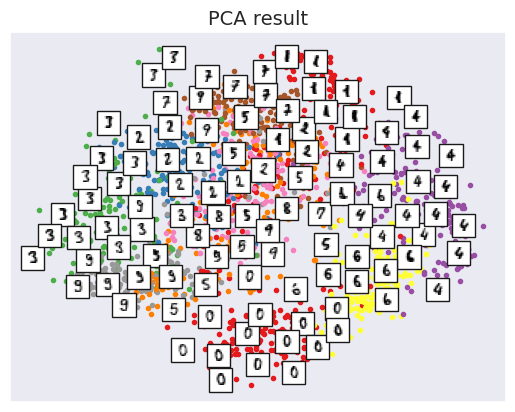

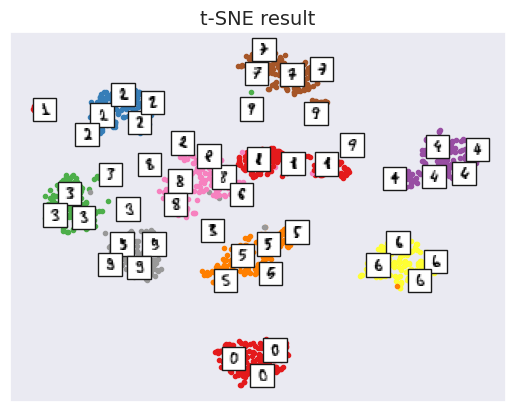

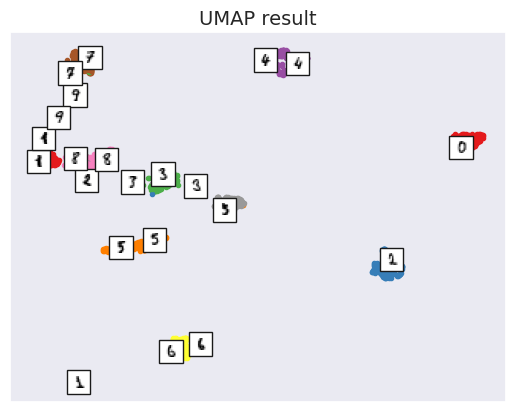

In [21]:
plot_embedding(embed_pca, "PCA result")
plot_embedding(embed_tsne, "t-SNE result")
plot_embedding(embed_umap, "UMAP result")

We see that PCA did actually separate the different numbers. However, without labels, this was impossible to see.

t-SNE and UMAP, on the other hand, separate the numbers into discrete clusters quite well, providing more information about the local structure of the data.

So why does PCA fail?

### Directions of high variance, which PCA preserves, is not the same thing as local similarity

On many datasets, like the iris dataset, directions of high variance correspond to useful features for discerning between irisis.

On others, like MNIST, they often correspond to non-usefull stuff like stroke thickness, slant, or lighting.

Changing the objective function to similarity between pairs of digits can really improve clustering.

### Summary

* Visualizing a high-dimensional biological dataset in 2D is useful for understanding its intrinsic structure.
* Linear dimensionality reduction sometimes struggles to find discrete clusters
* This is because directions of greatest global variance do not always correspond to local similarity
* t-SNE and UMAP take two separate approaches to capturing local structure of a dataset
* t-SNE finds a low dimensional space where the distances between pairs nearest neighbor points are as close as possible to the high dimensional space
* UMAP matches local neighborhoods between the low and high dimensional spaces
* Both have various hyperparameters that drastically influence output (such as n neighbors)
* Neither preserves global distance

### References
Informal introduction to t-SNE, by creator. [Google TechTalk](https://www.youtube.com/watch?v=RJVL80Gg3lA).

Formal introduction to t-SNE: L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. _Journal of Machine Learning Research_ 9(Nov):2579-2605, 2008.

Using the Barnes-Hut approximation: L.J.P. van der Maaten. Accelerating t-SNE using Tree-Based Algorithms. _Journal of Machine Learning Research_ 15(Oct):3221-3245, 2014.


